# Measuring Synaptic Short Term Plasticity

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to measure short term plasticity and its relationship to cell subclass.

For an introduction to the Jupyter Notebook interface interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
import numpy as np
import scipy.stats
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_pair_dataframe

### 1. Load the data

First, load up the "small" database from release 1.0 and query all cell `pairs` for mouse projects.

In [2]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_current('small')

# Load all synapses associated with mouse multipatch experiments
pairs = db.pair_query(
    experiment_type='standard multipatch',
    species='mouse',
    synapse=True,
    preload=['cell', 'synapse'],
).dataframe()

print("loaded %d synapses" % len(pairs))

loaded 1805 synapses


## 2. Classify cells

We will pick four simple class defintions for this analysis:

In [3]:
cell_classes = {
    'pyr': CellClass(cell_class='ex', name='pyr'),
    'pvalb': CellClass(cre_type='pvalb', name='pvalb'),
    'sst': CellClass(cre_type='sst', name='sst'),
    'vip': CellClass(cre_type='vip', name='vip'),
}   

In [4]:
# add new columns to the dataframe that apply the classification defined above
classify_pair_dataframe(cell_classes, pairs, col_names=('pre_class', 'post_class'))

## 3. Calculate average STP metric for each pre/post pairing

In [5]:
stp = pairs.pivot_table('dynamics.stp_induction_50hz', 'pre_class', 'post_class', aggfunc=np.mean)

# sort rows/cols into the expected order
order = list(cell_classes)
stp = stp[order].loc[order]

stp

post_class,pyr,pvalb,sst,vip
pre_class,,,,
pyr,-0.336121,-0.236252,0.153188,-0.054481
pvalb,-0.498625,-0.475758,-0.347782,-0.263452
sst,-0.125576,-0.133408,-0.168907,0.288444
vip,-0.163041,-0.103669,0.045582,-0.012254


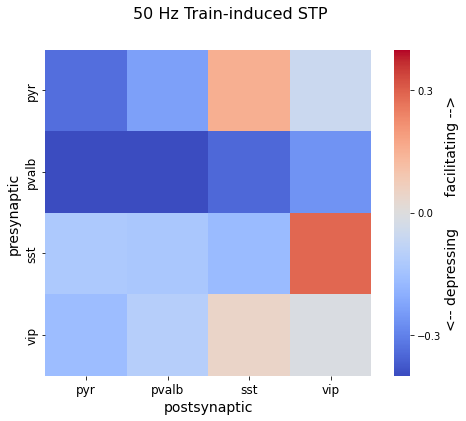

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(stp, cmap='coolwarm', vmin=-0.4, vmax=0.4, square=True, ax=ax,
                cbar_kws={"ticks":[-0.3, 0, 0.3], 'label': '<-- depressing       facilitating -->'})

fig.suptitle("50 Hz Train-induced STP", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)

## Alternatively, we can calculate the average resting state variance for each pairing

In [7]:
var = pairs.pivot_table('dynamics.variability_resting_state', 'pre_class', 'post_class', aggfunc=np.mean)

# sort rows/cols into the expected order
order = list(cell_classes)
var = var[order].loc[order]

var

post_class,pyr,pvalb,sst,vip
pre_class,,,,
pyr,-0.339417,0.490162,1.822031,1.548100
pvalb,-0.833936,-0.919017,-0.719812,-0.142069
sst,-0.230243,-0.159587,0.125349,0.076180
vip,0.539063,0.579907,0.502864,0.271833


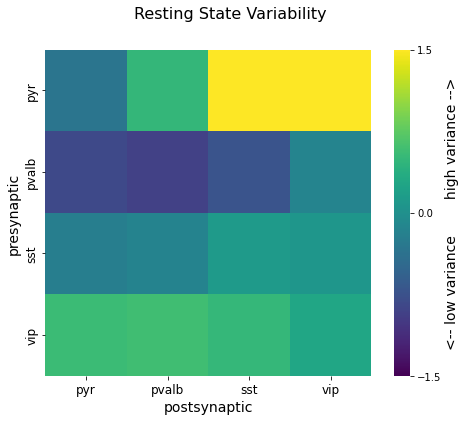

In [8]:
fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(var, cmap='viridis', vmin=-1.5, vmax=1.5, square=True, ax=ax,
                cbar_kws={"ticks":[-1.5, 0, 1.5], 'label': '<-- low variance        high variance -->'})

fig.suptitle("Resting State Variability", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)

## 4. Extract multiple synaptic properties and plot as matrices

Plotting synaptic properties among cell sublcasses in matrices like these is common enough that we have provided a convenince function to do just that called `cell_class_matrix`

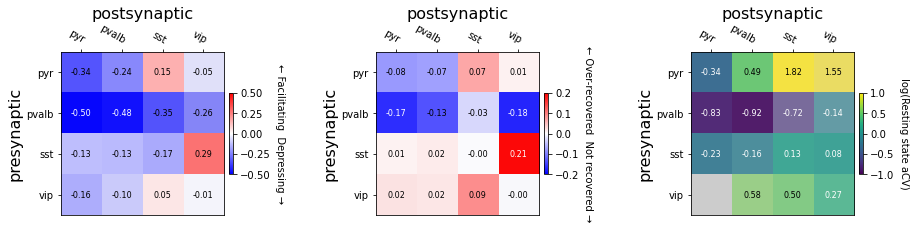

In [9]:
from aisynphys.ui.notebook import cell_class_matrix

fig,ax = plt.subplots(1, 3, figsize=(16, 3))

metrics = ['stp_induction_50hz', 'stp_recovery_250ms', 'variability_resting_state']

for i, metric in enumerate(metrics):
    cell_class_matrix(
        pre_classes=cell_classes, 
        post_classes=cell_classes,
        metric=metric, 
        class_labels=None, ax=ax[i],
        db=db, pair_query_args={
            'experiment_type': 'standard multipatch',
            'synapse': True,
            'species': 'mouse',
        }
    );